Ng-learning in one shot

In [190]:
import os
import torch
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from random import shuffle
import numpy as np
from torch_geometric.nn import GCNConv, Linear
from torch_geometric.utils import negative_sampling, dropout_edge
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from random import sample
from ipywidgets import IntProgress
from IPython.display import display
import time
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from sklearn.model_selection import StratifiedKFold, train_test_split

In [30]:

data_files_list = ["./export/"+f for f in os.listdir("./export") ]
instance_dict = {}
instance_additionals = {}
set_sizes_dict = {}
for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                if cnt == 4:
                    instance_additionals[instance] = []
                    split_line = line.split()
                    instance_additionals[instance].append([int(i) for i in split_line])
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

ng_dict = {}
cnt = -1
with open("ng_outs.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        set_sizes_dict[instance] = sum(sum(i) for i in ng_dict[instance])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [45]:
ordered_difficulty = [(k,v) for k,v in set_sizes_dict.items()]
ordered_difficulty = sorted(ordered_difficulty, key=lambda tup: tup[1], reverse=True)
instances_to_add = [ordered_difficulty[i][0] for i in range(0,1000)]
# instances_remaining = [ordered_difficulty[i][0] for i in range(1000,len(ordered_difficulty))]
# easy_instances = sample(instances_remaining, 2000)
instance_list = instances_to_add #+ easy_instances

In [46]:
data_files_list = ["./export2/"+f for f in os.listdir("./export2") ]

for dir_str in data_files_list:
    with open(dir_str, 'r') as text_file:
        cnt = 0
        instance = ""
        for line in text_file:
            if cnt < 9:
                if cnt == 0:
                    instance = line.split()[0]
                    instance_dict[instance] = []
                if cnt == 4:
                    instance_additionals[instance] = []
                    split_line = line.split()
                    instance_additionals[instance].append([int(i) for i in split_line])
                cnt += 1
                continue
            split_line = line.split()
            instance_dict[instance].append([int(i) for i in split_line])
        text_file.close()

cnt = -1
with open("ng_outs_JLA.csv", 'r') as text_file:
    for line in text_file:
        if cnt < 1:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict:
            ng_dict[instance] = [[0 for i in range(101)]]
        ng_dict[instance].append([0] + [int(i) for i in split_line_list[5:]])
        set_sizes_dict[instance] = sum(sum(i) for i in ng_dict[instance])
        # add new instances
        instance_list.append(instance)
        if len(split_line_list[5:]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [107]:
data_list = []
# aux_data_list = []


for instance_name in instance_list:
    instance = instance_dict[instance_name]
    attr = []
    for i in instance:
        attr.append(i[1:] + instance_additionals[instance_name][0])
    y = torch.tensor(ng_dict[instance_name], dtype=torch.float)
    # x = nn.functional.normalize( torch.tensor(attr, dtype=torch.float) )
    x = torch.tensor(attr, dtype=torch.float)
    pos = []
    tw_sets_dict = {}
    for i in instance:
        pos.append([i[1], i[2]])
    pos = torch.tensor(pos, dtype=torch.double)
    # edge_index = knn_graph(pos, 15)
    data_list.append(Data(x=x,
                        #   y=y,
                          edge_index=y.nonzero().t().contiguous(), 
                          pos=pos))
    # aux_data_list.append(instance_additionals[instance_name])

In [108]:
def add_edge_labels(graph):
    transform = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False)
    return transform(graph)

labeled_graphs = [add_edge_labels(graph) for graph in data_list]
shuffle(labeled_graphs)

train_size = [g[0] for g in labeled_graphs]
val_size = [g[1] for g in labeled_graphs]
test_size = [g[2] for g in labeled_graphs]

train_loader = DataLoader(train_size, batch_size=100, shuffle=True)
val_loader = DataLoader(val_size, batch_size=100, shuffle=False)
test_loader = DataLoader(test_size, batch_size=100, shuffle=False)

In [202]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.edge_dropout = 0.1
        self.dropout = 0.1
        self.linear1 = Linear(hidden_channels, hidden_channels)
        self.linear2 = Linear(hidden_channels, hidden_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.linear1(x).relu()
        x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        # x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        # edge_index, _ = dropout_edge(edge_index, p=self.edge_dropout, training=self.training)
        x = self.conv2(x, edge_index).relu()
        # x = torch.nn.functional.dropout(x, p=self.dropout, training=self.training)
        # edge_index, _ = dropout_edge(edge_index, p=self.edge_dropout, training=self.training)
        x = self.conv3(x, edge_index).relu()
        return self.conv4(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [203]:
model_ed = Net(data_list[0].num_features, 64, 32).to(device)
optimizer = torch.optim.Adam(params=model_ed.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [204]:
def train(loader, epoch):
    model_ed.train()
    total_loss = 0

    if epoch == 8:
        for g in optimizer.param_groups:
            g['lr'] = 0.001

    for batch in loader:
        optimizer.zero_grad()
        z = model_ed.encode(batch.x, batch.edge_index)

        # We perform a new round of negative sampling for every training epoch:
        neg_edge_index = negative_sampling(
            edge_index=batch.edge_index, num_nodes=batch.num_nodes,
            num_neg_samples=batch.edge_label_index.size(1), method='sparse')

        # Concat positive and negative edge indices.
        edge_label_index = torch.cat(
            [batch.edge_label_index, neg_edge_index],
            dim=-1,
        )
        # Label for positive edges: 1, for negative edges: 0.
        edge_label = torch.cat([
            batch.edge_label,
            batch.edge_label.new_zeros(neg_edge_index.size(1))
        ], dim=0)

        # Note: The model is trained in a supervised manner using the given
        # `edge_label_index` and `edge_label` targets.
        out = model_ed.decode(z, edge_label_index).view(-1)
        loss = criterion(out, edge_label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


@torch.no_grad()
def test(loader):
    model_ed.eval()
    all_out = []
    all_labels = []

    for batch in loader:
        z = model_ed.encode(batch.x, batch.edge_index)
        out = model_ed.decode(z, batch.edge_label_index).view(-1).sigmoid()
        all_out.append(out.cpu().numpy())
        all_labels.append(batch.edge_label.cpu().numpy())

    all_out = np.concatenate(all_out)
    all_labels = np.concatenate(all_labels)
    return roc_auc_score(all_labels, all_out), [all_labels], [all_out]

In [205]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
loss_collection = []
val_auc_collection = []
last_epoch = 30
for epoch in range(1, last_epoch + 1):
    if epoch > 5:
        rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
        rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
        if rate_of_change_in_loss * -1 > 0:
            if rate_of_change_in_val * -1 > 0:
                y_true = all_labels[0]
                y_pred = all_out[0]

                fpr, tpr, _ = roc_curve(y_true, y_pred)
                roc_auc = roc_auc_score(y_true, y_pred)

                plt.figure(1)
                plt.plot([0, 1], [0, 1], 'k-')
                plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                plt.xlabel('False positive rate')
                plt.ylabel('True positive rate')
                plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
                plt.legend(loc='best')
                plt.show()
                break
    loss = train(train_loader, epoch)
    val_auc, _, _ = test(val_loader)
    test_auc, all_labels, all_out = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    loss_collection.append(loss)
    val_auc_collection.append(val_auc)
    if epoch == last_epoch:
        y_true = all_labels[0]
        y_pred = all_out[0]

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k-')
        plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
        plt.legend(loc='best')
        plt.show()


print(f'Final Test: {final_test_auc:.4f}')

Epoch: 001, Loss: 5.8334, Val: 0.7384, Test: 0.7394
Epoch: 002, Loss: 0.5454, Val: 0.8044, Test: 0.8055
Epoch: 003, Loss: 0.4875, Val: 0.8212, Test: 0.8230
Epoch: 004, Loss: 0.4660, Val: 0.8299, Test: 0.8316


KeyboardInterrupt: 

Epoch: 031, Loss: 0.4051, Val: 0.9398, Test: 0.9413
Epoch: 032, Loss: 0.4044, Val: 0.9406, Test: 0.9421
Epoch: 033, Loss: 0.4038, Val: 0.9392, Test: 0.9407
Epoch: 034, Loss: 0.4034, Val: 0.9395, Test: 0.9410
Epoch: 035, Loss: 0.4030, Val: 0.9408, Test: 0.9424
Epoch: 036, Loss: 0.4026, Val: 0.9406, Test: 0.9421
Epoch: 037, Loss: 0.4023, Val: 0.9408, Test: 0.9423


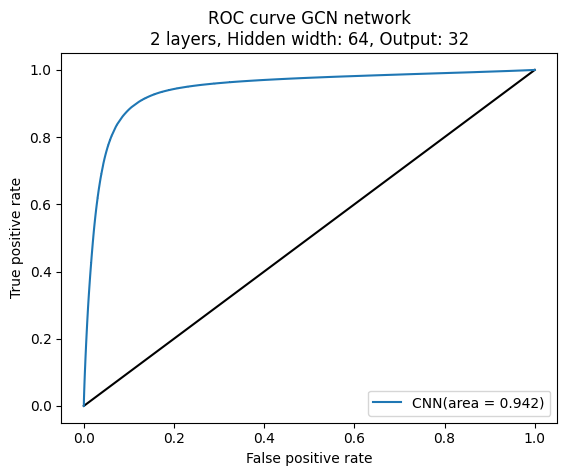

Final Test: 0.9424


In [138]:
# Train/Test Loop
best_val_auc = final_test_auc = 0
loss_collection = []
val_auc_collection = []
last_epoch = 60
for epoch in range(31, last_epoch + 1):
    if epoch > 35:
        rate_of_change_in_loss_e = [loss_collection[-i]-loss_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_val_e = [val_auc_collection[-i]-val_auc_collection[-i-1] for i in range(1,3)]
        rate_of_change_in_loss = sum(rate_of_change_in_loss_e)/len(rate_of_change_in_loss_e)
        rate_of_change_in_val = sum(rate_of_change_in_val_e)/len(rate_of_change_in_val_e)
        if rate_of_change_in_loss * -1 > 0:
            if rate_of_change_in_val * -1 > 0:
                y_true = all_labels[0]
                y_pred = all_out[0]

                fpr, tpr, _ = roc_curve(y_true, y_pred)
                roc_auc = roc_auc_score(y_true, y_pred)

                plt.figure(1)
                plt.plot([0, 1], [0, 1], 'k-')
                plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
                plt.xlabel('False positive rate')
                plt.ylabel('True positive rate')
                plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
                plt.legend(loc='best')
                plt.show()
                break
    loss = train(train_loader, epoch)
    val_auc, _, _ = test(val_loader)
    test_auc, all_labels, all_out = test(test_loader)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    loss_collection.append(loss)
    val_auc_collection.append(val_auc)
    if epoch == last_epoch:
        y_true = all_labels[0]
        y_pred = all_out[0]

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = roc_auc_score(y_true, y_pred)

        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k-')
        plt.plot(fpr, tpr, label='CNN(area = {:.3f})'.format(roc_auc))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve GCN network\n2 layers, Hidden width: 64, Output: 32')
        plt.legend(loc='best')
        plt.show()


print(f'Final Test: {final_test_auc:.4f}')

In [195]:
instance_name = "C204.txt"
folder = ""
ng_outs_file = "ng_outs_oct.csv"
ng_outs_folder = ""

individual_instance = {}
instance_additionals_t = {}
with open(folder+instance_name, 'r') as text_file:
    cnt = 0
    instance = ""
    for line in text_file:
        if cnt < 9:
            if cnt == 0:
                instance = line.split()[0]
                individual_instance[instance] = []
            if cnt == 4:
                instance_additionals_t[instance] = []
                split_line = line.split()
                instance_additionals_t[instance].append([int(i) for i in split_line])
            cnt += 1
            continue
        split_line = line.split()
        individual_instance[instance].append([int(i) for i in split_line])
    text_file.close()

ng_dict_aux = {}
cnt = -1
with open(ng_outs_folder+ng_outs_file, 'r') as text_file:
    for line in text_file:
        if cnt < 2:
            cnt += 1
            continue
        raw_line = line.strip()
        split_line_list = raw_line.split(sep=";")
        instance = split_line_list[3]
        if instance not in ng_dict_aux:
            ng_dict_aux[instance] = [[0 for i in range(101)]]
        ng_dict_aux[instance].append([0] + [int(i) for i in split_line_list[5:-1]])
        if len(split_line_list[5:-1]) != 100:
            print("case found for instance "+instance)
    text_file.close()

In [196]:
instance_name = "C204"
instance = individual_instance[instance_name]
y = torch.tensor(ng_dict_aux[instance_name], dtype=torch.float)
attr = []
for i in instance:
    attr.append(i[1:] + instance_additionals_t[instance_name][0])
x = torch.nn.functional.normalize( torch.tensor(attr, dtype=torch.float) )
# x = torch.tensor(attr, dtype=torch.float)
pos = []
tw_sets_dict = {}
for i in instance:
    pos.append([i[1], i[2]])
pos = torch.tensor(pos, dtype=torch.double)
# edge_index = knn_graph(pos, 15)
raw_instance = Data(x=x, y=y, edge_index=y.nonzero().t().contiguous(), pos=pos)

In [197]:
enc = model_ed.encode(raw_instance.x, torch.tensor([[],[]], dtype=torch.int64))
dec = model_ed.decode_all(enc)

In [187]:
len(dec[0])

10201

In [92]:
for i in range(len(dec[0])):
    print((dec[0][i].tolist(), dec[1][i].tolist()))

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 5)
(0, 6)
(0, 7)
(0, 10)
(0, 12)
(0, 14)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 24)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 31)
(0, 32)
(0, 33)
(0, 34)
(0, 35)
(0, 36)
(0, 37)
(0, 40)
(0, 41)
(0, 42)
(0, 43)
(0, 45)
(0, 46)
(0, 47)
(0, 48)
(0, 49)
(0, 50)
(0, 51)
(0, 52)
(0, 54)
(0, 56)
(0, 57)
(0, 59)
(0, 60)
(0, 61)
(0, 63)
(0, 64)
(0, 65)
(0, 66)
(0, 68)
(0, 70)
(0, 71)
(0, 72)
(0, 73)
(0, 75)
(0, 78)
(0, 80)
(0, 81)
(0, 82)
(0, 83)
(0, 85)
(0, 86)
(0, 88)
(0, 89)
(0, 90)
(0, 91)
(0, 93)
(0, 94)
(0, 95)
(0, 96)
(0, 97)
(0, 98)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 14)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 29)
(1, 30)
(1, 31)
(1, 32)
(1, 33)
(1, 34)
(1, 40)
(1, 41)
(1, 42)
(1, 43)
(1, 45)
(1, 46)
(1, 47)
(1, 48)
(1, 49)
(1, 50)
(1, 51)
(1, 52)
(1, 54)
(1, 56)
(1, 57)
(1, 59)
(1, 60)
(1, 61)
(1, 63)
(1, 64)
(1, 65)
(1, 66)
